In [33]:
import re
import time
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

import jieba
from pymongo import MongoClient
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Phrases
from gensim.corpora import Dictionary
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
client = MongoClient()

In [130]:
client.paper.cs_paper_abs.find_one()['summary']

"Graph Neural Networks (GNNs) are limited in their expressive power, struggle\nwith long-range interactions and lack a principled way to model higher-order\nstructures. These problems can be attributed to the strong coupling between the\ncomputational graph and the input graph structure. The recently proposed\nMessage Passing Simplicial Networks naturally decouple these elements by\nperforming message passing on the clique complex of the graph. Nevertheless,\nthese models are severely constrained by the rigid combinatorial structure of\nSimplicial Complexes (SCs). In this work, we extend recent theoretical results\non SCs to regular Cell Complexes, topological objects that flexibly subsume SCs\nand graphs. We show that this generalisation provides a powerful set of graph\n``lifting'' transformations, each leading to a unique hierarchical message\npassing procedure. The resulting methods, which we collectively call CW\nNetworks (CWNs), are strictly more powerful than the WL test and, in

In [131]:
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
doc = tokenizer.tokenize(client.paper.cs_paper_abs.find_one()['summary'].lower())
doc = [lemmatizer.lemmatize(token) for token in doc]
print(doc)

['graph', 'neural', 'network', 'gnns', 'are', 'limited', 'in', 'their', 'expressive', 'power', 'struggle', 'with', 'long', 'range', 'interaction', 'and', 'lack', 'a', 'principled', 'way', 'to', 'model', 'higher', 'order', 'structure', 'these', 'problem', 'can', 'be', 'attributed', 'to', 'the', 'strong', 'coupling', 'between', 'the', 'computational', 'graph', 'and', 'the', 'input', 'graph', 'structure', 'the', 'recently', 'proposed', 'message', 'passing', 'simplicial', 'network', 'naturally', 'decouple', 'these', 'element', 'by', 'performing', 'message', 'passing', 'on', 'the', 'clique', 'complex', 'of', 'the', 'graph', 'nevertheless', 'these', 'model', 'are', 'severely', 'constrained', 'by', 'the', 'rigid', 'combinatorial', 'structure', 'of', 'simplicial', 'complex', 'sc', 'in', 'this', 'work', 'we', 'extend', 'recent', 'theoretical', 'result', 'on', 'sc', 'to', 'regular', 'cell', 'complex', 'topological', 'object', 'that', 'flexibly', 'subsume', 'sc', 'and', 'graph', 'we', 'show', 'th

In [146]:
class Corpus:
    def __init__(self, collection):
        self.collection = collection
        self.tokenizer = RegexpTokenizer(r'\w+')
        self.lemmatizer = WordNetLemmatizer()

    def __iter__(self):
        docs = self.collection.find()
        for i, doc in enumerate(docs):
            doc = doc['summary'].lower().replace('_', '')
            doc = self.tokenizer.tokenize(doc)         
            doc = [token for token in doc if not token.isnumeric()]
            doc = [token for token in doc if len(token) > 1]
            doc = [self.lemmatizer.lemmatize(token) for token in doc]
            yield doc

class BigramCorpus:
    def __init__(self, data_gen, bigram):
        self.data_gen = data_gen
        self.bigram = bigram
    
    def __iter__(self):
        for i, doc in enumerate(self.data_gen):
            for token in self.bigram[doc]:
                if '_' in token:
                    doc.append(token)
            yield doc
            
class BOW:
    def __init__(self, data_gen, dictionary):
        self.data_gen = data_gen
        self.dictionary = dictionary
        
    def __iter__(self):
        for doc in self.data_gen:
            yield self.dictionary.doc2bow(doc)
            
def result_write(collection, bigram, dictionary, model):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
        
    docs = collection.find()
    result = {}
    for doc in docs:
        rawid = doc['_id']
        doc = doc['summary'].lower().replace('_', '')
        doc = tokenizer.tokenize(doc)         
        doc = [token for token in doc if not token.isnumeric()]
        doc = [token for token in doc if len(token) > 1]
        doc = [lemmatizer.lemmatize(token) for token in doc]
        for token in bigram[doc]:
            doc.append(token)
            
        x = dictionary.doc2bow(doc)
        scores = model[x]
        result[rawid] = sorted(scores, key=lambda ele:ele[1], reverse=True)[0][0]

    for rawid in result:
        collection.find_one_and_update({'_id': rawid}, {'$set': {'topic_index': result[rawid]}})
        

In [133]:
corpus = Corpus(client.paper.cs_paper_abs)
bigram = Phrases(corpus, min_count=20)
bigram_corpus = BigramCorpus(corpus, bigram)
dictionary = Dictionary(bigram_corpus)
dictionary.filter_extremes(no_below=20, no_above=0.5)

my_corpus = BOW(bigram_corpus, dictionary)

2021-06-25 11:15:53,391 : INFO : collecting all words and their counts
2021-06-25 11:15:53,395 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-06-25 11:15:59,016 : INFO : PROGRESS: at sentence #10000, processed 1690308 words and 531030 word types
2021-06-25 11:15:59,222 : INFO : collected 545731 token types (unigram + bigrams) from a corpus of 1752380 words and 10363 sentences
2021-06-25 11:15:59,223 : INFO : merged Phrases<545731 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>
2021-06-25 11:15:59,224 : INFO : Phrases lifecycle event {'msg': 'built Phrases<545731 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000> in 5.83s', 'datetime': '2021-06-25T11:15:59.224032', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-74-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-06-25 11:15:59,228 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-06-25 1

In [140]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 100
chunksize = 2000
passes = 20
iterations = 50
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=my_corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2021-06-25 11:27:41,665 : INFO : using autotuned alpha, starting with [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
2021-06-25 11:27:41,667 : INFO : using serial LDA version on this node
2021-06-25 11:27:41,709 : WARNING : input corpus stream has no len(); counting documents
2021-06-25 11:27:49,245 : INFO : running online (multi-pass) LDA training, 100 topics, 20 passes over the supplied corpus of 10363 documents, updating model once every 2

2021-06-25 11:28:04,933 : INFO : topic #17 (0.009): 0.020*"malicious" + 0.020*"abstraction" + 0.019*"differentiable" + 0.018*"contact" + 0.017*"robustly" + 0.014*"triggered" + 0.012*"satisfaction" + 0.011*"minor" + 0.011*"application" + 0.010*"saddle"
2021-06-25 11:28:04,934 : INFO : topic #57 (0.012): 0.024*"network" + 0.017*"graph" + 0.016*"neural" + 0.015*"model" + 0.012*"can" + 0.009*"training" + 0.008*"performance" + 0.008*"method" + 0.008*"based" + 0.008*"layer"
2021-06-25 11:28:04,935 : INFO : topic #72 (0.012): 0.011*"method" + 0.009*"feature" + 0.008*"which" + 0.008*"model" + 0.007*"information" + 0.007*"from" + 0.007*"learning" + 0.007*"graph" + 0.006*"based" + 0.006*"show"
2021-06-25 11:28:04,935 : INFO : topic #28 (0.012): 0.027*"image" + 0.017*"method" + 0.011*"learning" + 0.010*"model" + 0.008*"from" + 0.007*"segmentation" + 0.007*"object" + 0.007*"feature" + 0.006*"training" + 0.006*"network"
2021-06-25 11:28:04,936 : INFO : topic diff=2.102772, rho=0.577350
2021-06-25 1

2021-06-25 11:28:17,460 : INFO : topic #23 (0.010): 0.064*"cloud" + 0.040*"monte" + 0.040*"monte_carlo" + 0.040*"carlo" + 0.026*"point" + 0.026*"apps" + 0.024*"carried_out" + 0.023*"map" + 0.023*"carried" + 0.023*"threat"
2021-06-25 11:28:17,461 : INFO : topic #62 (0.013): 0.025*"algorithm" + 0.016*"problem" + 0.010*"which" + 0.010*"guarantee" + 0.008*"constraint" + 0.007*"show" + 0.007*"least" + 0.007*"linear" + 0.007*"it" + 0.006*"matching"
2021-06-25 11:28:17,462 : INFO : topic #57 (0.013): 0.030*"network" + 0.025*"graph" + 0.020*"neural" + 0.017*"model" + 0.011*"can" + 0.010*"performance" + 0.009*"based" + 0.009*"gnns" + 0.008*"training" + 0.008*"method"
2021-06-25 11:28:17,462 : INFO : topic #28 (0.014): 0.038*"image" + 0.021*"method" + 0.010*"from" + 0.009*"feature" + 0.008*"model" + 0.008*"segmentation" + 0.008*"learning" + 0.007*"network" + 0.006*"face" + 0.006*"based"
2021-06-25 11:28:17,464 : INFO : topic diff=2.361434, rho=0.408248
2021-06-25 11:28:19,023 : INFO : PROGRESS: 

2021-06-25 11:28:32,632 : INFO : topic #62 (0.014): 0.028*"algorithm" + 0.018*"problem" + 0.013*"guarantee" + 0.011*"which" + 0.007*"show" + 0.007*"linear" + 0.007*"constraint" + 0.007*"it" + 0.007*"matching" + 0.006*"sampling"
2021-06-25 11:28:32,633 : INFO : topic #12 (0.015): 0.015*"system" + 0.009*"data" + 0.009*"software" + 0.009*"ha" + 0.009*"technology" + 0.009*"development" + 0.009*"paper" + 0.008*"application" + 0.008*"been" + 0.008*"science"
2021-06-25 11:28:32,634 : INFO : topic #28 (0.016): 0.046*"image" + 0.023*"method" + 0.010*"from" + 0.010*"feature" + 0.008*"segmentation" + 0.008*"model" + 0.007*"face" + 0.007*"propose" + 0.007*"we_propose" + 0.007*"network"
2021-06-25 11:28:32,635 : INFO : topic diff=2.315456, rho=0.373158
2021-06-25 11:28:34,067 : INFO : PROGRESS: pass 1, at document #8000/10363
2021-06-25 11:28:37,533 : INFO : optimized alpha [0.012852541, 0.013777148, 0.011592761, 0.012848001, 0.0117873, 0.0116461115, 0.012129236, 0.011324393, 0.010719623, 0.0119782

2021-06-25 11:28:43,432 : INFO : topic #12 (0.017): 0.015*"system" + 0.010*"technology" + 0.010*"research" + 0.010*"paper" + 0.009*"ha" + 0.008*"tool" + 0.008*"development" + 0.008*"been" + 0.008*"study" + 0.008*"their"
2021-06-25 11:28:43,433 : INFO : topic #28 (0.018): 0.048*"image" + 0.024*"method" + 0.011*"from" + 0.009*"feature" + 0.008*"segmentation" + 0.008*"face" + 0.008*"network" + 0.007*"based" + 0.007*"we_propose" + 0.007*"propose"
2021-06-25 11:28:43,434 : INFO : topic diff=2.114778, rho=0.373158
2021-06-25 11:28:44,862 : INFO : PROGRESS: pass 2, at document #2000/10363
2021-06-25 11:28:47,997 : INFO : optimized alpha [0.0147543615, 0.015888441, 0.0122589525, 0.013801983, 0.01274435, 0.012325994, 0.013373316, 0.01199623, 0.01089144, 0.01278927, 0.011711467, 0.013634726, 0.01836505, 0.012909119, 0.013244035, 0.012471706, 0.01266377, 0.011330688, 0.012955226, 0.013014015, 0.0131402975, 0.011525815, 0.013453819, 0.010888559, 0.012313768, 0.01287281, 0.010806063, 0.015046987, 0

2021-06-25 11:28:57,461 : INFO : topic #12 (0.020): 0.014*"system" + 0.010*"ha" + 0.010*"paper" + 0.010*"research" + 0.009*"technology" + 0.009*"software" + 0.009*"development" + 0.009*"application" + 0.009*"been" + 0.008*"have"
2021-06-25 11:28:57,461 : INFO : topic #28 (0.021): 0.054*"image" + 0.025*"method" + 0.012*"from" + 0.009*"feature" + 0.008*"face" + 0.008*"segmentation" + 0.008*"propose" + 0.008*"we_propose" + 0.007*"network" + 0.007*"based"
2021-06-25 11:28:57,462 : INFO : topic diff=1.523641, rho=0.349610
2021-06-25 11:28:58,868 : INFO : PROGRESS: pass 2, at document #8000/10363
2021-06-25 11:29:01,982 : INFO : optimized alpha [0.017905254, 0.018672436, 0.013361341, 0.015097363, 0.01395147, 0.013159569, 0.014917, 0.012705208, 0.011373746, 0.013843187, 0.012421357, 0.014798203, 0.021064047, 0.014061287, 0.014033484, 0.013507796, 0.013364523, 0.012187803, 0.013912592, 0.013953972, 0.014230631, 0.012327584, 0.014591917, 0.011500131, 0.013075975, 0.014032572, 0.011351925, 0.016

2021-06-25 11:29:07,182 : INFO : topic #28 (0.023): 0.054*"image" + 0.026*"method" + 0.012*"from" + 0.009*"feature" + 0.009*"face" + 0.008*"segmentation" + 0.008*"based" + 0.008*"network" + 0.008*"we_propose" + 0.008*"propose"
2021-06-25 11:29:07,182 : INFO : topic #12 (0.023): 0.013*"system" + 0.011*"paper" + 0.011*"technology" + 0.011*"research" + 0.010*"ha" + 0.009*"analysis" + 0.009*"development" + 0.009*"application" + 0.009*"been" + 0.008*"have"
2021-06-25 11:29:07,184 : INFO : topic diff=1.184308, rho=0.349610
2021-06-25 11:29:08,689 : INFO : PROGRESS: pass 3, at document #2000/10363
2021-06-25 11:29:11,294 : INFO : optimized alpha [0.021457434, 0.021424714, 0.014172943, 0.016106408, 0.015152086, 0.0139579605, 0.016615845, 0.0135000935, 0.011624786, 0.014849338, 0.0132025145, 0.01560636, 0.024682604, 0.015201136, 0.015082316, 0.014327961, 0.014104533, 0.013017016, 0.015009448, 0.014960274, 0.015402043, 0.013312547, 0.015727641, 0.012262603, 0.013880589, 0.014734402, 0.011830944,

2021-06-25 11:29:19,526 : INFO : topic #12 (0.027): 0.012*"system" + 0.011*"paper" + 0.011*"ha" + 0.010*"application" + 0.010*"technology" + 0.010*"research" + 0.010*"software" + 0.010*"development" + 0.009*"been" + 0.009*"have"
2021-06-25 11:29:19,527 : INFO : topic diff=0.813842, rho=0.330022
2021-06-25 11:29:20,944 : INFO : PROGRESS: pass 3, at document #8000/10363
2021-06-25 11:29:23,319 : INFO : optimized alpha [0.02686888, 0.024700286, 0.015493524, 0.017409671, 0.016664598, 0.014885201, 0.018560022, 0.014347247, 0.012151743, 0.016166065, 0.013969373, 0.016890105, 0.027752254, 0.016506767, 0.015947007, 0.01544518, 0.014822995, 0.013904978, 0.01611366, 0.016037125, 0.016651101, 0.014434006, 0.01698425, 0.013129178, 0.0146978265, 0.015984802, 0.012437893, 0.020302152, 0.02586155, 0.016480092, 0.014303519, 0.016269142, 0.017268727, 0.017126953, 0.016588347, 0.016430309, 0.018715361, 0.016428996, 0.020832717, 0.023129305, 0.012670133, 0.022916269, 0.015335324, 0.015998153, 0.019929113

2021-06-25 11:29:27,990 : INFO : topic diff=0.655006, rho=0.330022
2021-06-25 11:29:29,442 : INFO : PROGRESS: pass 4, at document #2000/10363
2021-06-25 11:29:31,597 : INFO : optimized alpha [0.0320606, 0.027718639, 0.016429685, 0.018385457, 0.018024283, 0.015743684, 0.020622522, 0.015195096, 0.012415904, 0.017363653, 0.014800243, 0.017788209, 0.031694394, 0.017758824, 0.017052807, 0.016338615, 0.0155865485, 0.014767799, 0.0172906, 0.017087167, 0.017861525, 0.015765477, 0.018217115, 0.014167635, 0.015514005, 0.016828168, 0.012979082, 0.021635199, 0.028329376, 0.01773612, 0.014970723, 0.017594, 0.018353768, 0.017922116, 0.017791092, 0.017530432, 0.02084972, 0.017853508, 0.022936787, 0.026332308, 0.013285371, 0.02446573, 0.01651424, 0.017052218, 0.021525145, 0.023614356, 0.01780637, 0.020816281, 0.016007217, 0.029064866, 0.020316515, 0.017089743, 0.018227397, 0.017696872, 0.025893748, 0.013704148, 0.0169628, 0.016701624, 0.02287512, 0.0139027545, 0.015533228, 0.016150506, 0.027769115, 0.

2021-06-25 11:29:43,222 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:29:43,249 : INFO : topic #8 (0.013): 0.067*"asr" + 0.060*"divergence" + 0.056*"automatic" + 0.042*"chain" + 0.027*"autoregressive" + 0.026*"mathbf" + 0.023*"non" + 0.021*"collapse" + 0.019*"deletion" + 0.017*"suffers"
2021-06-25 11:29:43,250 : INFO : topic #63 (0.014): 0.064*"table" + 0.049*"cell" + 0.044*"hand" + 0.031*"plant" + 0.027*"instruction" + 0.027*"affected" + 0.026*"de" + 0.025*"type" + 0.023*"column" + 0.021*"row"
2021-06-25 11:29:43,250 : INFO : topic #49 (0.033): 0.113*"model" + 0.019*"metric" + 0.018*"generative" + 0.014*"evaluation" + 0.013*"generation" + 0.013*"have" + 0.013*"bias" + 0.013*"work" + 0.010*"can" + 0.009*"prediction"
2021-06-25 11:29:43,251 : INFO : topic #12 (0.035): 0.012*"paper" + 0.011*"technology" + 0.011*"ha" + 0.010*"software" + 0.010*"system" + 0.010*"application" + 0.010*"development" + 0.010*"research" + 0.009*"analysis" + 0.009*"ha

2021-06-25 11:29:52,164 : INFO : topic #63 (0.014): 0.073*"table" + 0.056*"cell" + 0.047*"hand" + 0.033*"column" + 0.030*"row" + 0.026*"type" + 0.026*"de" + 0.025*"affected" + 0.020*"plant" + 0.019*"instruction"
2021-06-25 11:29:52,165 : INFO : topic #49 (0.037): 0.119*"model" + 0.018*"metric" + 0.018*"generative" + 0.013*"have" + 0.013*"bias" + 0.012*"evaluation" + 0.012*"generation" + 0.012*"work" + 0.010*"prediction" + 0.010*"can"
2021-06-25 11:29:52,165 : INFO : topic #12 (0.039): 0.012*"paper" + 0.012*"technology" + 0.011*"ha" + 0.011*"research" + 0.010*"software" + 0.010*"development" + 0.010*"analysis" + 0.010*"application" + 0.009*"system" + 0.009*"it"
2021-06-25 11:29:52,166 : INFO : topic #0 (0.047): 0.045*"be" + 0.038*"not" + 0.029*"can" + 0.022*"or" + 0.019*"it" + 0.018*"but" + 0.015*"can_be" + 0.015*"only" + 0.014*"they" + 0.013*"these"
2021-06-25 11:29:52,167 : INFO : topic diff=0.333205, rho=0.299054
2021-06-25 11:29:53,617 : INFO : PROGRESS: pass 5, at document #4000/10

2021-06-25 11:30:03,486 : INFO : topic #49 (0.042): 0.121*"model" + 0.019*"metric" + 0.018*"generative" + 0.014*"evaluation" + 0.013*"generation" + 0.013*"work" + 0.013*"bias" + 0.013*"have" + 0.010*"can" + 0.010*"prediction"
2021-06-25 11:30:03,486 : INFO : topic #12 (0.042): 0.012*"paper" + 0.011*"technology" + 0.011*"application" + 0.011*"software" + 0.010*"ha" + 0.010*"development" + 0.010*"research" + 0.010*"analysis" + 0.009*"system" + 0.009*"it"
2021-06-25 11:30:03,487 : INFO : topic #0 (0.057): 0.045*"be" + 0.039*"not" + 0.031*"can" + 0.022*"or" + 0.020*"it" + 0.018*"but" + 0.016*"can_be" + 0.015*"only" + 0.014*"they" + 0.013*"these"
2021-06-25 11:30:03,488 : INFO : topic diff=0.277365, rho=0.299054
2021-06-25 11:30:04,991 : INFO : PROGRESS: pass 5, at document #10000/10363
2021-06-25 11:30:06,998 : INFO : optimized alpha [0.06111606, 0.039280426, 0.021187315, 0.022344427, 0.023827126, 0.019072019, 0.028542217, 0.018477205, 0.0140763875, 0.022294505, 0.017596014, 0.021989154, 0

2021-06-25 11:30:11,284 : INFO : topic #12 (0.046): 0.012*"paper" + 0.012*"technology" + 0.011*"research" + 0.011*"software" + 0.010*"development" + 0.010*"ha" + 0.010*"analysis" + 0.010*"application" + 0.009*"it" + 0.009*"science"
2021-06-25 11:30:11,285 : INFO : topic #0 (0.066): 0.046*"be" + 0.039*"not" + 0.032*"can" + 0.023*"or" + 0.020*"it" + 0.018*"but" + 0.017*"can_be" + 0.015*"only" + 0.014*"they" + 0.014*"these"
2021-06-25 11:30:11,286 : INFO : topic diff=0.227358, rho=0.286516
2021-06-25 11:30:12,727 : INFO : PROGRESS: pass 6, at document #4000/10363
2021-06-25 11:30:14,621 : INFO : optimized alpha [0.06974622, 0.042959783, 0.02234175, 0.023110375, 0.025412157, 0.02004065, 0.03090517, 0.019358562, 0.014396269, 0.02356339, 0.018382225, 0.02313263, 0.047041923, 0.023507725, 0.02141198, 0.021343445, 0.018916745, 0.01890915, 0.022618016, 0.021857994, 0.023239946, 0.022648716, 0.0238289, 0.019366952, 0.019161202, 0.021240884, 0.015698431, 0.030494412, 0.038950793, 0.024543826, 0.0

2021-06-25 11:30:21,322 : INFO : topic #0 (0.078): 0.046*"be" + 0.040*"not" + 0.034*"can" + 0.022*"or" + 0.021*"it" + 0.018*"but" + 0.017*"can_be" + 0.015*"only" + 0.014*"they" + 0.014*"these"
2021-06-25 11:30:21,323 : INFO : topic diff=0.194410, rho=0.286516
2021-06-25 11:30:22,762 : INFO : PROGRESS: pass 6, at document #10000/10363
2021-06-25 11:30:24,548 : INFO : optimized alpha [0.08281544, 0.046157256, 0.024083031, 0.024447834, 0.02757036, 0.021106541, 0.0333057, 0.020594789, 0.015032922, 0.025347319, 0.019327449, 0.024546886, 0.05063263, 0.02489857, 0.022474485, 0.022937015, 0.019723311, 0.019836705, 0.024125021, 0.023233693, 0.02471447, 0.024798505, 0.025248822, 0.020665307, 0.020033497, 0.022425776, 0.016428052, 0.03312464, 0.041019313, 0.02644059, 0.01851626, 0.026631989, 0.024938807, 0.023180954, 0.02478875, 0.02407447, 0.039392672, 0.028243933, 0.040284928, 0.05218799, 0.017029792, 0.034233537, 0.024098935, 0.023067923, 0.03355845, 0.03790138, 0.024099045, 0.033091553, 0.021

2021-06-25 11:30:29,849 : INFO : PROGRESS: pass 7, at document #4000/10363
2021-06-25 11:30:31,681 : INFO : optimized alpha [0.091644324, 0.049736984, 0.02529293, 0.02518446, 0.029208433, 0.022062512, 0.035567395, 0.02149537, 0.015366757, 0.026563928, 0.020124903, 0.025719637, 0.053590994, 0.026120858, 0.023510309, 0.02404322, 0.02041248, 0.020874279, 0.0252263, 0.024183394, 0.025757564, 0.026482532, 0.026340462, 0.02198316, 0.020872405, 0.0231578, 0.016996302, 0.03483897, 0.04378134, 0.028006272, 0.01926469, 0.02812561, 0.026076747, 0.02401668, 0.025814869, 0.025136832, 0.043319654, 0.030321948, 0.0433802, 0.0574059, 0.017653955, 0.03526073, 0.025382323, 0.024114825, 0.03549583, 0.040292818, 0.0249677, 0.035198607, 0.022342134, 0.055841617, 0.029913535, 0.024269428, 0.025743473, 0.026807873, 0.0527946, 0.018984646, 0.03013559, 0.022288056, 0.036550507, 0.017324314, 0.02251658, 0.021699084, 0.050824158, 0.017148767, 0.03789466, 0.031431835, 0.029576404, 0.01811747, 0.036559492, 0.02195

2021-06-25 11:30:41,191 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:30:41,216 : INFO : topic #8 (0.016): 0.063*"asr" + 0.059*"automatic" + 0.055*"divergence" + 0.039*"cross" + 0.039*"chain" + 0.031*"autoregressive" + 0.030*"non" + 0.026*"deletion" + 0.022*"mathbf" + 0.020*"collapse"
2021-06-25 11:30:41,217 : INFO : topic #59 (0.018): 0.103*"privacy" + 0.037*"data" + 0.033*"federated" + 0.031*"private" + 0.028*"client" + 0.027*"fl" + 0.020*"preserving" + 0.018*"information" + 0.018*"differential" + 0.016*"dp"
2021-06-25 11:30:41,218 : INFO : topic #49 (0.061): 0.135*"model" + 0.017*"metric" + 0.017*"generative" + 0.014*"generation" + 0.014*"evaluation" + 0.014*"bias" + 0.013*"work" + 0.012*"prediction" + 0.012*"have" + 0.009*"can"
2021-06-25 11:30:41,218 : INFO : topic #39 (0.065): 0.026*"been" + 0.026*"research" + 0.023*"ha" + 0.017*"have" + 0.012*"there" + 0.012*"these" + 0.012*"study" + 0.012*"ha_been" + 0.011*"work" + 0.010*"future"
202

2021-06-25 11:30:47,925 : INFO : topic #26 (0.018): 0.087*"phase" + 0.041*"irs" + 0.040*"post" + 0.034*"taking" + 0.027*"top" + 0.025*"consider" + 0.025*"surface" + 0.023*"account" + 0.022*"we_consider" + 0.021*"intelligent"
2021-06-25 11:30:47,926 : INFO : topic #49 (0.064): 0.137*"model" + 0.017*"generative" + 0.016*"metric" + 0.014*"bias" + 0.014*"generation" + 0.013*"evaluation" + 0.013*"prediction" + 0.013*"work" + 0.011*"have" + 0.010*"can"
2021-06-25 11:30:47,926 : INFO : topic #39 (0.071): 0.029*"been" + 0.025*"research" + 0.024*"ha" + 0.018*"have" + 0.012*"there" + 0.012*"ha_been" + 0.012*"study" + 0.012*"these" + 0.011*"work" + 0.010*"future"
2021-06-25 11:30:47,927 : INFO : topic #0 (0.114): 0.048*"be" + 0.041*"not" + 0.036*"can" + 0.024*"or" + 0.022*"it" + 0.019*"can_be" + 0.018*"but" + 0.015*"only" + 0.014*"they" + 0.014*"these"
2021-06-25 11:30:47,928 : INFO : topic diff=0.121978, rho=0.265545
2021-06-25 11:30:49,377 : INFO : PROGRESS: pass 8, at document #6000/10363
2021

2021-06-25 11:30:57,004 : INFO : topic #39 (0.079): 0.030*"been" + 0.025*"ha" + 0.024*"research" + 0.019*"have" + 0.013*"ha_been" + 0.013*"there" + 0.012*"these" + 0.012*"study" + 0.012*"work" + 0.011*"have_been"
2021-06-25 11:30:57,004 : INFO : topic #0 (0.129): 0.047*"be" + 0.041*"not" + 0.038*"can" + 0.023*"or" + 0.022*"it" + 0.020*"can_be" + 0.018*"but" + 0.015*"they" + 0.015*"only" + 0.014*"these"
2021-06-25 11:30:57,006 : INFO : topic diff=0.112476, rho=0.265545
2021-06-25 11:30:57,285 : INFO : PROGRESS: pass 8, at document #10363/10363
2021-06-25 11:30:57,509 : INFO : optimized alpha [0.12686901, 0.059313104, 0.030025972, 0.028623145, 0.03579586, 0.025460768, 0.042602833, 0.025096413, 0.017009867, 0.03175264, 0.023093233, 0.030147726, 0.06291885, 0.030194528, 0.027205719, 0.029043166, 0.022971256, 0.024237152, 0.02970643, 0.028505318, 0.0299101, 0.033539154, 0.030495554, 0.026670158, 0.023864191, 0.026400855, 0.019062907, 0.04165732, 0.050940376, 0.033965137, 0.021565052, 0.0341

2021-06-25 11:31:03,577 : INFO : topic #0 (0.136): 0.049*"be" + 0.041*"not" + 0.038*"can" + 0.024*"or" + 0.022*"it" + 0.020*"can_be" + 0.018*"but" + 0.014*"they" + 0.014*"only" + 0.014*"these"
2021-06-25 11:31:03,578 : INFO : topic diff=0.098860, rho=0.256651
2021-06-25 11:31:05,006 : INFO : PROGRESS: pass 9, at document #6000/10363
2021-06-25 11:31:06,509 : INFO : optimized alpha [0.14105254, 0.06285052, 0.031891, 0.029662112, 0.03796444, 0.026501944, 0.04478407, 0.026140463, 0.017567432, 0.03346309, 0.023911763, 0.03176243, 0.06554626, 0.031372707, 0.028010735, 0.030853042, 0.02359995, 0.02519872, 0.030999804, 0.029421538, 0.031132009, 0.03544556, 0.031508822, 0.02805499, 0.02462281, 0.027385892, 0.019755846, 0.04473411, 0.05344826, 0.03584728, 0.022209525, 0.035868753, 0.03129579, 0.027799018, 0.03108478, 0.030205555, 0.0631656, 0.04061709, 0.061771203, 0.08685699, 0.020618599, 0.041473605, 0.031716984, 0.028745022, 0.046166632, 0.052773442, 0.029883845, 0.044569083, 0.026689028, 0.

2021-06-25 11:31:12,785 : INFO : PROGRESS: pass 9, at document #10363/10363
2021-06-25 11:31:13,004 : INFO : optimized alpha [0.14793171, 0.06469478, 0.03290388, 0.030550007, 0.039735742, 0.027556794, 0.046566293, 0.027204668, 0.018016594, 0.034965534, 0.024803057, 0.032819744, 0.06793091, 0.032422785, 0.029273823, 0.032196093, 0.024435975, 0.026204772, 0.03239464, 0.030845286, 0.032347776, 0.03803377, 0.032719173, 0.029543513, 0.025640717, 0.028355652, 0.020284433, 0.046017826, 0.055133913, 0.03755948, 0.022874044, 0.037544303, 0.032263566, 0.028480487, 0.032472398, 0.031302463, 0.0667507, 0.04263341, 0.06542535, 0.09311494, 0.021320326, 0.04264906, 0.032891728, 0.029944917, 0.0478785, 0.05498637, 0.031026192, 0.04656153, 0.027792955, 0.07702835, 0.03701418, 0.029926825, 0.031742558, 0.034199443, 0.0741184, 0.023765197, 0.04499896, 0.027496044, 0.047082376, 0.019966504, 0.028954484, 0.026391694, 0.0697371, 0.02142286, 0.04930495, 0.041559078, 0.039518487, 0.021995204, 0.04865389, 0.02

2021-06-25 11:31:21,719 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:31:21,744 : INFO : topic #8 (0.019): 0.060*"automatic" + 0.059*"divergence" + 0.056*"asr" + 0.039*"chain" + 0.036*"cross" + 0.034*"non" + 0.031*"autoregressive" + 0.028*"additive" + 0.026*"mathbf" + 0.020*"deletion"
2021-06-25 11:31:21,745 : INFO : topic #59 (0.021): 0.102*"privacy" + 0.041*"federated" + 0.034*"data" + 0.030*"private" + 0.030*"fl" + 0.026*"client" + 0.020*"preserving" + 0.019*"dp" + 0.018*"differential" + 0.016*"information"
2021-06-25 11:31:21,745 : INFO : topic #49 (0.082): 0.144*"model" + 0.018*"generative" + 0.016*"metric" + 0.014*"prediction" + 0.014*"generation" + 0.014*"evaluation" + 0.014*"work" + 0.014*"bias" + 0.010*"have" + 0.009*"can"
2021-06-25 11:31:21,746 : INFO : topic #39 (0.101): 0.036*"been" + 0.029*"ha" + 0.023*"have" + 0.023*"research" + 0.016*"ha_been" + 0.014*"have_been" + 0.012*"there" + 0.012*"these" + 0.012*"study" + 0.011*"work"


2021-06-25 11:31:28,144 : INFO : topic #59 (0.021): 0.099*"privacy" + 0.035*"federated" + 0.035*"data" + 0.027*"client" + 0.027*"private" + 0.026*"fl" + 0.021*"differential" + 0.019*"dp" + 0.019*"differential_privacy" + 0.018*"shared"
2021-06-25 11:31:28,144 : INFO : topic #49 (0.084): 0.147*"model" + 0.018*"generative" + 0.017*"metric" + 0.015*"bias" + 0.014*"prediction" + 0.013*"evaluation" + 0.013*"work" + 0.013*"generation" + 0.010*"have" + 0.009*"can"
2021-06-25 11:31:28,145 : INFO : topic #39 (0.107): 0.036*"been" + 0.028*"ha" + 0.024*"have" + 0.024*"research" + 0.015*"have_been" + 0.014*"ha_been" + 0.012*"study" + 0.012*"these" + 0.012*"there" + 0.012*"work"
2021-06-25 11:31:28,145 : INFO : topic #0 (0.168): 0.051*"be" + 0.041*"not" + 0.040*"can" + 0.025*"or" + 0.023*"it" + 0.021*"can_be" + 0.018*"but" + 0.015*"they" + 0.015*"only" + 0.014*"these"
2021-06-25 11:31:28,146 : INFO : topic diff=0.104994, rho=0.248594
2021-06-25 11:31:29,617 : INFO : PROGRESS: pass 11, at document #2

2021-06-25 11:31:37,035 : INFO : topic #39 (0.116): 0.039*"been" + 0.030*"ha" + 0.025*"have" + 0.022*"research" + 0.017*"ha_been" + 0.015*"have_been" + 0.012*"these" + 0.012*"there" + 0.012*"study" + 0.012*"work"
2021-06-25 11:31:37,035 : INFO : topic #0 (0.183): 0.050*"be" + 0.041*"not" + 0.040*"can" + 0.024*"or" + 0.023*"it" + 0.022*"can_be" + 0.018*"but" + 0.015*"they" + 0.014*"only" + 0.014*"these"
2021-06-25 11:31:37,036 : INFO : topic diff=0.072732, rho=0.241251
2021-06-25 11:31:38,417 : INFO : PROGRESS: pass 11, at document #8000/10363
2021-06-25 11:31:39,815 : INFO : optimized alpha [0.1895106, 0.07329093, 0.03809363, 0.033748608, 0.046338838, 0.031232659, 0.052565772, 0.03078988, 0.019888442, 0.040519368, 0.027484596, 0.03735665, 0.075803325, 0.03591434, 0.03229297, 0.03756416, 0.02664953, 0.029368863, 0.0367543, 0.03448125, 0.036409725, 0.045200225, 0.03605084, 0.034039304, 0.028459283, 0.031632904, 0.022360547, 0.054669384, 0.061744723, 0.04376345, 0.024937224, 0.043182682, 

2021-06-25 11:31:43,336 : INFO : topic diff=0.093658, rho=0.241251
2021-06-25 11:31:44,744 : INFO : PROGRESS: pass 12, at document #2000/10363
2021-06-25 11:31:46,121 : INFO : optimized alpha [0.19228354, 0.074652724, 0.038802367, 0.034411613, 0.047819935, 0.032186665, 0.05394791, 0.031714294, 0.020189585, 0.041675497, 0.028276915, 0.038013138, 0.07795146, 0.03676223, 0.033369247, 0.038656894, 0.027326256, 0.030200789, 0.037938397, 0.035498787, 0.03754593, 0.047525898, 0.03690831, 0.035401512, 0.029375868, 0.032358427, 0.02285204, 0.05544948, 0.06354331, 0.045150403, 0.025551574, 0.04438076, 0.03684254, 0.03158543, 0.037035137, 0.03613917, 0.08449067, 0.05234772, 0.08280583, 0.124000505, 0.024084281, 0.047737785, 0.038444504, 0.0339259, 0.05711193, 0.06575559, 0.035453532, 0.054412097, 0.032277074, 0.092670046, 0.042286787, 0.03413786, 0.036046736, 0.03963801, 0.087373644, 0.027387265, 0.055644613, 0.03124183, 0.055156536, 0.022150492, 0.033569586, 0.02976642, 0.08225118, 0.025171544, 

2021-06-25 11:31:54,939 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:31:54,964 : INFO : topic #8 (0.021): 0.060*"divergence" + 0.058*"automatic" + 0.055*"asr" + 0.045*"chain" + 0.039*"cross" + 0.033*"non" + 0.030*"additive" + 0.029*"autoregressive" + 0.026*"mathbf" + 0.022*"error"
2021-06-25 11:31:54,965 : INFO : topic #59 (0.023): 0.105*"privacy" + 0.043*"federated" + 0.032*"data" + 0.030*"private" + 0.029*"fl" + 0.028*"client" + 0.021*"preserving" + 0.019*"dp" + 0.018*"mechanism" + 0.018*"differential"
2021-06-25 11:31:54,966 : INFO : topic #49 (0.097): 0.152*"model" + 0.018*"generative" + 0.016*"metric" + 0.015*"prediction" + 0.015*"work" + 0.014*"bias" + 0.014*"evaluation" + 0.014*"generation" + 0.009*"such" + 0.009*"have"
2021-06-25 11:31:54,966 : INFO : topic #39 (0.132): 0.041*"been" + 0.032*"ha" + 0.027*"have" + 0.022*"research" + 0.018*"ha_been" + 0.017*"have_been" + 0.013*"these" + 0.012*"work" + 0.012*"there" + 0.012*"study"
2021

2021-06-25 11:32:01,597 : INFO : topic #59 (0.023): 0.103*"privacy" + 0.040*"federated" + 0.034*"data" + 0.029*"client" + 0.029*"private" + 0.026*"fl" + 0.020*"preserving" + 0.019*"differential" + 0.017*"differential_privacy" + 0.017*"shared"
2021-06-25 11:32:01,598 : INFO : topic #49 (0.099): 0.156*"model" + 0.018*"generative" + 0.016*"metric" + 0.016*"prediction" + 0.014*"bias" + 0.014*"work" + 0.013*"generation" + 0.013*"evaluation" + 0.009*"such" + 0.009*"can"
2021-06-25 11:32:01,598 : INFO : topic #39 (0.137): 0.042*"been" + 0.032*"ha" + 0.028*"have" + 0.022*"research" + 0.018*"have_been" + 0.017*"ha_been" + 0.013*"these" + 0.012*"study" + 0.012*"work" + 0.012*"there"
2021-06-25 11:32:01,599 : INFO : topic #0 (0.213): 0.051*"be" + 0.042*"can" + 0.041*"not" + 0.025*"or" + 0.023*"it" + 0.022*"can_be" + 0.018*"but" + 0.015*"they" + 0.015*"these" + 0.014*"only"
2021-06-25 11:32:01,600 : INFO : topic diff=0.056898, rho=0.228328
2021-06-25 11:32:02,998 : INFO : PROGRESS: pass 13, at doc

2021-06-25 11:32:10,159 : INFO : topic #39 (0.144): 0.043*"been" + 0.033*"ha" + 0.029*"have" + 0.021*"research" + 0.018*"ha_been" + 0.018*"have_been" + 0.013*"these" + 0.012*"work" + 0.012*"there" + 0.012*"study"
2021-06-25 11:32:10,160 : INFO : topic #0 (0.232): 0.051*"be" + 0.043*"can" + 0.041*"not" + 0.024*"or" + 0.024*"it" + 0.022*"can_be" + 0.018*"but" + 0.015*"they" + 0.014*"only" + 0.014*"these"
2021-06-25 11:32:10,161 : INFO : topic diff=0.052942, rho=0.228328
2021-06-25 11:32:11,593 : INFO : PROGRESS: pass 13, at document #10000/10363
2021-06-25 11:32:12,937 : INFO : optimized alpha [0.23852131, 0.080836736, 0.0434812, 0.03753078, 0.05382562, 0.036316965, 0.058966022, 0.03528214, 0.022065734, 0.046889413, 0.030793307, 0.0417577, 0.08497121, 0.03963054, 0.0361362, 0.04349559, 0.029682023, 0.03313101, 0.04222355, 0.038999032, 0.04134415, 0.054792996, 0.040094003, 0.039642315, 0.03204875, 0.035647623, 0.024902578, 0.0633111, 0.068773635, 0.051002268, 0.027367756, 0.049518626, 0.0

2021-06-25 11:32:16,339 : INFO : topic diff=0.051625, rho=0.222599
2021-06-25 11:32:17,737 : INFO : PROGRESS: pass 14, at document #4000/10363
2021-06-25 11:32:19,068 : INFO : optimized alpha [0.24111727, 0.08295285, 0.044147782, 0.037924916, 0.054843355, 0.037456322, 0.059980594, 0.035995565, 0.022338714, 0.047696825, 0.031424034, 0.042535778, 0.0858137, 0.040335696, 0.036943283, 0.044274244, 0.030225266, 0.03403078, 0.04301061, 0.03962031, 0.042234264, 0.05627362, 0.04071065, 0.040860616, 0.032833237, 0.03617995, 0.02537041, 0.06415189, 0.07064091, 0.05228544, 0.027965462, 0.05034538, 0.040924422, 0.034492116, 0.040938362, 0.040574692, 0.09992518, 0.06113299, 0.09953045, 0.15127696, 0.026643924, 0.052220583, 0.043249488, 0.03747948, 0.065089114, 0.07480694, 0.0394098, 0.06080829, 0.03678758, 0.1070257, 0.046647232, 0.03760529, 0.040087704, 0.04456195, 0.09806676, 0.030694226, 0.06420991, 0.034795035, 0.062210098, 0.02415597, 0.037674826, 0.032877482, 0.09224911, 0.028634507, 0.063509

2021-06-25 11:32:27,491 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:32:27,516 : INFO : topic #8 (0.023): 0.058*"automatic" + 0.056*"divergence" + 0.049*"asr" + 0.042*"cross" + 0.041*"chain" + 0.033*"non" + 0.032*"additive" + 0.032*"autoregressive" + 0.025*"deletion" + 0.023*"error"
2021-06-25 11:32:27,517 : INFO : topic #59 (0.024): 0.106*"privacy" + 0.041*"federated" + 0.032*"private" + 0.030*"data" + 0.028*"fl" + 0.028*"client" + 0.020*"preserving" + 0.019*"mechanism" + 0.018*"differential" + 0.017*"dp"
2021-06-25 11:32:27,518 : INFO : topic #49 (0.111): 0.162*"model" + 0.017*"generative" + 0.016*"prediction" + 0.015*"metric" + 0.015*"generation" + 0.015*"work" + 0.014*"bias" + 0.014*"evaluation" + 0.009*"such" + 0.008*"can"
2021-06-25 11:32:27,518 : INFO : topic #39 (0.159): 0.044*"been" + 0.034*"ha" + 0.030*"have" + 0.020*"research" + 0.019*"ha_been" + 0.018*"have_been" + 0.013*"these" + 0.013*"work" + 0.012*"there" + 0.012*"study"
202

2021-06-25 11:32:33,915 : INFO : topic #59 (0.025): 0.101*"privacy" + 0.043*"federated" + 0.031*"data" + 0.031*"private" + 0.030*"fl" + 0.028*"client" + 0.020*"dp" + 0.020*"preserving" + 0.018*"differential" + 0.017*"mechanism"
2021-06-25 11:32:33,915 : INFO : topic #49 (0.112): 0.163*"model" + 0.017*"prediction" + 0.017*"generative" + 0.015*"metric" + 0.014*"bias" + 0.014*"work" + 0.014*"generation" + 0.014*"evaluation" + 0.009*"such" + 0.008*"can"
2021-06-25 11:32:33,916 : INFO : topic #39 (0.162): 0.045*"been" + 0.034*"ha" + 0.030*"have" + 0.020*"research" + 0.019*"have_been" + 0.019*"ha_been" + 0.013*"these" + 0.012*"work" + 0.012*"study" + 0.012*"there"
2021-06-25 11:32:33,916 : INFO : topic #0 (0.266): 0.052*"be" + 0.044*"can" + 0.041*"not" + 0.025*"or" + 0.024*"it" + 0.023*"can_be" + 0.018*"but" + 0.015*"these" + 0.015*"they" + 0.014*"only"
2021-06-25 11:32:33,918 : INFO : topic diff=0.045992, rho=0.217281
2021-06-25 11:32:35,369 : INFO : PROGRESS: pass 15, at document #6000/103

2021-06-25 11:32:42,362 : INFO : topic #39 (0.169): 0.045*"been" + 0.034*"ha" + 0.031*"have" + 0.020*"research" + 0.019*"ha_been" + 0.018*"have_been" + 0.013*"these" + 0.013*"work" + 0.012*"there" + 0.012*"study"
2021-06-25 11:32:42,363 : INFO : topic #0 (0.289): 0.052*"be" + 0.045*"can" + 0.040*"not" + 0.025*"or" + 0.024*"it" + 0.024*"can_be" + 0.017*"but" + 0.015*"they" + 0.014*"only" + 0.014*"these"
2021-06-25 11:32:42,364 : INFO : topic diff=0.045996, rho=0.217281
2021-06-25 11:32:42,651 : INFO : PROGRESS: pass 15, at document #10363/10363
2021-06-25 11:32:42,846 : INFO : optimized alpha [0.27932265, 0.086660326, 0.04725933, 0.04035162, 0.059447132, 0.041442454, 0.06333887, 0.03917803, 0.023953008, 0.05169278, 0.033744775, 0.04526426, 0.08970803, 0.04265287, 0.039719913, 0.047703024, 0.032332033, 0.03681053, 0.046723306, 0.04295458, 0.045530718, 0.06277019, 0.043409314, 0.044633128, 0.035340283, 0.039048307, 0.027158415, 0.0692524, 0.074555516, 0.05714712, 0.029741, 0.054154787, 0.

2021-06-25 11:32:48,477 : INFO : topic diff=0.042065, rho=0.212327
2021-06-25 11:32:49,994 : INFO : PROGRESS: pass 16, at document #6000/10363
2021-06-25 11:32:51,321 : INFO : optimized alpha [0.30253717, 0.08897859, 0.04875896, 0.04111839, 0.060967878, 0.042745534, 0.064559326, 0.04010572, 0.024446169, 0.053065054, 0.03436031, 0.046416312, 0.09127902, 0.043463998, 0.040166598, 0.048931655, 0.032765046, 0.03751667, 0.04767883, 0.0434056, 0.046570886, 0.063982494, 0.04398725, 0.045705408, 0.035875067, 0.03982775, 0.027805861, 0.07233097, 0.07637377, 0.05868326, 0.030227441, 0.055296388, 0.044420715, 0.037015043, 0.04434905, 0.044307314, 0.113570586, 0.06877139, 0.115403995, 0.1724173, 0.02894142, 0.0558174, 0.047474906, 0.040338095, 0.07198912, 0.08302217, 0.04300503, 0.066038914, 0.041001614, 0.11854677, 0.05018596, 0.040226825, 0.043558802, 0.049149804, 0.106212474, 0.03385792, 0.071688436, 0.03806848, 0.06821432, 0.025863528, 0.04116808, 0.0356413, 0.10133571, 0.031841855, 0.06869586

2021-06-25 11:32:57,603 : INFO : merging changes from 363 documents into a model of 10363 documents
2021-06-25 11:32:57,628 : INFO : topic #8 (0.025): 0.060*"automatic" + 0.051*"divergence" + 0.042*"chain" + 0.038*"additive" + 0.038*"non" + 0.037*"cross" + 0.034*"autoregressive" + 0.034*"asr" + 0.024*"error" + 0.023*"deletion"
2021-06-25 11:32:57,629 : INFO : topic #59 (0.026): 0.103*"privacy" + 0.038*"federated" + 0.029*"data" + 0.028*"private" + 0.028*"client" + 0.027*"fl" + 0.021*"differential" + 0.020*"dp" + 0.019*"differential_privacy" + 0.018*"shared"
2021-06-25 11:32:57,629 : INFO : topic #49 (0.119): 0.167*"model" + 0.018*"generative" + 0.017*"prediction" + 0.015*"metric" + 0.015*"bias" + 0.014*"work" + 0.014*"evaluation" + 0.014*"generation" + 0.009*"such" + 0.008*"can"
2021-06-25 11:32:57,630 : INFO : topic #39 (0.174): 0.045*"been" + 0.034*"ha" + 0.032*"have" + 0.021*"research" + 0.020*"have_been" + 0.018*"ha_been" + 0.013*"these" + 0.012*"work" + 0.012*"study" + 0.011*"ther

2021-06-25 11:33:06,071 : INFO : topic #59 (0.027): 0.106*"privacy" + 0.044*"federated" + 0.031*"private" + 0.031*"fl" + 0.029*"data" + 0.027*"client" + 0.020*"preserving" + 0.020*"dp" + 0.018*"differential" + 0.018*"mechanism"
2021-06-25 11:33:06,071 : INFO : topic #49 (0.123): 0.167*"model" + 0.018*"generative" + 0.017*"prediction" + 0.015*"work" + 0.015*"generation" + 0.014*"bias" + 0.014*"metric" + 0.014*"evaluation" + 0.009*"such" + 0.008*"these"
2021-06-25 11:33:06,072 : INFO : topic #39 (0.180): 0.047*"been" + 0.035*"ha" + 0.033*"have" + 0.020*"research" + 0.019*"have_been" + 0.019*"ha_been" + 0.013*"these" + 0.012*"work" + 0.012*"there" + 0.012*"study"
2021-06-25 11:33:06,073 : INFO : topic #0 (0.336): 0.054*"be" + 0.046*"can" + 0.040*"not" + 0.025*"or" + 0.025*"can_be" + 0.024*"it" + 0.017*"but" + 0.015*"these" + 0.015*"they" + 0.014*"only"
2021-06-25 11:33:06,074 : INFO : topic diff=0.040047, rho=0.207697
2021-06-25 11:33:07,485 : INFO : PROGRESS: pass 17, at document #8000/1

2021-06-25 11:33:12,159 : INFO : topic #39 (0.181): 0.046*"been" + 0.034*"ha" + 0.033*"have" + 0.021*"research" + 0.020*"have_been" + 0.018*"ha_been" + 0.013*"these" + 0.012*"work" + 0.012*"study" + 0.011*"there"
2021-06-25 11:33:12,160 : INFO : topic #0 (0.344): 0.055*"be" + 0.047*"can" + 0.039*"not" + 0.026*"or" + 0.025*"can_be" + 0.024*"it" + 0.017*"but" + 0.015*"they" + 0.015*"these" + 0.014*"only"
2021-06-25 11:33:12,161 : INFO : topic diff=0.059895, rho=0.207697
2021-06-25 11:33:13,581 : INFO : PROGRESS: pass 18, at document #2000/10363
2021-06-25 11:33:14,839 : INFO : optimized alpha [0.35164577, 0.091971636, 0.051116895, 0.04301102, 0.0647468, 0.04639928, 0.06713885, 0.043143053, 0.025836509, 0.05607412, 0.03638915, 0.0484502, 0.09535162, 0.045684528, 0.042248785, 0.05157618, 0.034487043, 0.039766807, 0.05078152, 0.045794986, 0.049769383, 0.06998072, 0.046076614, 0.048952773, 0.03809849, 0.042278484, 0.029632937, 0.07645831, 0.079712175, 0.0628143, 0.0317988, 0.0583295, 0.04639

2021-06-25 11:33:20,538 : INFO : topic diff=0.037164, rho=0.203357
2021-06-25 11:33:21,957 : INFO : PROGRESS: pass 18, at document #8000/10363
2021-06-25 11:33:23,226 : INFO : optimized alpha [0.3864831, 0.09374953, 0.052608136, 0.043855265, 0.066236764, 0.047743544, 0.06816297, 0.04410895, 0.026488982, 0.057476472, 0.036944143, 0.049600303, 0.096109495, 0.046374276, 0.042666204, 0.052740943, 0.03499512, 0.040561806, 0.051877104, 0.04650244, 0.05066774, 0.071210794, 0.04680677, 0.049846325, 0.038596027, 0.04328018, 0.030267088, 0.07987091, 0.080696374, 0.064460345, 0.032240663, 0.059611566, 0.04734073, 0.039147478, 0.04730158, 0.04732567, 0.124909855, 0.074639395, 0.12964761, 0.18830967, 0.031036934, 0.059226673, 0.050846066, 0.04320906, 0.077785276, 0.08981567, 0.04627393, 0.07016396, 0.045222998, 0.128476, 0.05314656, 0.042619485, 0.046900757, 0.053157814, 0.112361476, 0.036750205, 0.07750636, 0.041171737, 0.07368036, 0.027448192, 0.044150315, 0.03816971, 0.10910667, 0.03478304, 0.07

2021-06-25 11:33:29,901 : INFO : merging changes from 2000 documents into a model of 10363 documents
2021-06-25 11:33:29,926 : INFO : topic #8 (0.027): 0.059*"automatic" + 0.054*"divergence" + 0.041*"chain" + 0.041*"non" + 0.037*"cross" + 0.036*"additive" + 0.034*"autoregressive" + 0.024*"error" + 0.023*"deletion" + 0.022*"between"
2021-06-25 11:33:29,927 : INFO : topic #59 (0.028): 0.107*"privacy" + 0.042*"federated" + 0.030*"private" + 0.030*"client" + 0.027*"fl" + 0.027*"data" + 0.020*"preserving" + 0.020*"differential" + 0.018*"mechanism" + 0.017*"differential_privacy"
2021-06-25 11:33:29,927 : INFO : topic #38 (0.129): 0.033*"model" + 0.031*"performance" + 0.027*"accuracy" + 0.023*"than" + 0.018*"can" + 0.017*"training" + 0.017*"while" + 0.014*"better" + 0.014*"achieve" + 0.014*"time"
2021-06-25 11:33:29,928 : INFO : topic #39 (0.190): 0.047*"been" + 0.036*"ha" + 0.033*"have" + 0.020*"research" + 0.020*"have_been" + 0.019*"ha_been" + 0.013*"these" + 0.013*"work" + 0.012*"study" + 

2021-06-25 11:33:38,583 : INFO : topic #59 (0.028): 0.109*"privacy" + 0.044*"federated" + 0.031*"private" + 0.030*"fl" + 0.029*"client" + 0.026*"data" + 0.022*"preserving" + 0.020*"dp" + 0.019*"mechanism" + 0.018*"differential"
2021-06-25 11:33:38,584 : INFO : topic #38 (0.135): 0.032*"model" + 0.032*"performance" + 0.026*"accuracy" + 0.023*"than" + 0.018*"can" + 0.017*"while" + 0.016*"training" + 0.014*"time" + 0.014*"state" + 0.014*"better"
2021-06-25 11:33:38,584 : INFO : topic #39 (0.195): 0.047*"been" + 0.037*"ha" + 0.034*"have" + 0.020*"research" + 0.020*"have_been" + 0.019*"ha_been" + 0.013*"these" + 0.013*"work" + 0.012*"study" + 0.012*"there"
2021-06-25 11:33:38,585 : INFO : topic #0 (0.431): 0.055*"be" + 0.048*"can" + 0.038*"not" + 0.026*"can_be" + 0.026*"or" + 0.025*"it" + 0.017*"but" + 0.015*"these" + 0.014*"which" + 0.014*"they"
2021-06-25 11:33:38,586 : INFO : topic diff=0.032199, rho=0.199278
2021-06-25 11:33:40,090 : INFO : PROGRESS: pass 19, at document #10000/10363
20

In [147]:
result_write(client.paper.cs_paper_abs, bigram, dictionary, model)

In [141]:
model.show_topics()

[(8,
  '0.058*"automatic" + 0.052*"divergence" + 0.046*"chain" + 0.039*"additive" + 0.039*"non" + 0.038*"cross" + 0.035*"autoregressive" + 0.024*"deletion" + 0.023*"error" + 0.023*"between"'),
 (59,
  '0.105*"privacy" + 0.039*"federated" + 0.029*"private" + 0.028*"client" + 0.028*"fl" + 0.027*"data" + 0.021*"differential" + 0.020*"dp" + 0.019*"differential_privacy" + 0.019*"shared"'),
 (98,
  '0.073*"learning" + 0.055*"rl" + 0.054*"reinforcement" + 0.051*"reward" + 0.042*"reinforcement_learning" + 0.041*"exploration" + 0.039*"algorithm" + 0.038*"environment" + 0.021*"based" + 0.021*"state"'),
 (26,
  '0.082*"phase" + 0.051*"consider" + 0.045*"taking" + 0.044*"we_consider" + 0.040*"post" + 0.036*"irs" + 0.034*"surface" + 0.025*"intelligent" + 0.022*"account" + 0.022*"aided"'),
 (40,
  '0.118*"protocol" + 0.051*"sigma" + 0.039*"party" + 0.038*"message" + 0.032*"blockchain" + 0.030*"transaction" + 0.030*"dialog" + 0.030*"customer" + 0.028*"secure" + 0.024*"communication"'),
 (36,
  '0.318

In [154]:
bigram.save('saved/bigram.bin')
dictionary.save('saved/dictionary.bin')
model.save('saved/ldamodel.bin')

2021-06-25 11:57:11,687 : INFO : Phrases lifecycle event {'fname_or_handle': 'saved/bigram.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-06-25T11:57:11.687050', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-74-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-06-25 11:57:11,851 : INFO : saved saved/bigram.bin
2021-06-25 11:57:11,853 : INFO : Dictionary lifecycle event {'fname_or_handle': 'saved/dictionary.bin', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2021-06-25T11:57:11.853768', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-74-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'saving'}
2021-06-25 11:57:11,862 : INFO : saved saved/dictionary.bin
2021-06-25 11:57:11,865 : INFO : LdaState lifecycle event {'fname_or_handle': 'saved/ldamodel.bin.state', 'separate

In [142]:
text_iter = iter(corpus)
for doc in my_corpus:
    text = next(text_iter)
    scores = model[doc]
    cat = sorted(scores, key=lambda ele:ele[1], reverse=True)[0][0]
    if cat == 5:
        print(text)
        input('continue?')

['stereotactic', 'body', 'radiation', 'therapy', 'allows', 'for', 'precise', 'and', 'accurate', 'dose', 'delivery', 'organ', 'motion', 'during', 'treatment', 'bear', 'the', 'risk', 'of', 'undetected', 'high', 'dose', 'healthy', 'tissue', 'exposure', 'an', 'organ', 'very', 'susceptible', 'to', 'high', 'dose', 'is', 'the', 'oesophagus', 'it', 'low', 'contrast', 'on', 'ct', 'and', 'the', 'oblong', 'shape', 'render', 'motion', 'estimation', 'difficult', 'we', 'tackle', 'this', 'issue', 'by', 'modern', 'algorithm', 'to', 'measure', 'the', 'oesophageal', 'motion', 'voxel', 'wise', 'and', 'to', 'estimate', 'motion', 'related', 'dosimetric', 'impact', 'oesophageal', 'motion', 'wa', 'measured', 'using', 'deformable', 'image', 'registration', 'and', '4dct', 'of', 'internal', 'and', 'public', 'datasets', 'current', 'clinical', 'practice', 'of', 'contouring', 'the', 'organ', 'on', '3dct', 'wa', 'compared', 'to', 'timely', 'resolved', '4dct', 'contour', 'the', 'dosimetric', 'impact', 'of', 'the', '

KeyboardInterrupt: Interrupted by user

## 测试查重功能

In [6]:
documents = []
for doc in client.article.crawl.find():
    text = re.sub(r'\s+', ' ', doc['summary'])
    tokens = jieba.lcut(text)
    documents.append(TaggedDocument(tokens, [doc['_id']]))

Building prefix dict from the default dictionary ...
2021-08-27 14:35:13,333 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
2021-08-27 14:35:13,334 : DEBUG : Loading model from cache /tmp/jieba.cache
Loading model cost 0.397 seconds.
2021-08-27 14:35:13,731 : DEBUG : Loading model cost 0.397 seconds.
Prefix dict has been built successfully.
2021-08-27 14:35:13,732 : DEBUG : Prefix dict has been built successfully.


In [9]:
model = Doc2Vec(min_count=2)
model.build_vocab(documents)
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

2021-08-27 14:38:20,574 : DEBUG : starting a new internal lifecycle event log for Doc2Vec
2021-08-27 14:38:20,575 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w5,mc2,s0.001,t3)', 'datetime': '2021-08-27T14:38:20.574674', 'gensim': '4.0.1', 'python': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]', 'platform': 'Linux-5.4.0-81-generic-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}
2021-08-27 14:38:20,575 : INFO : collecting all words and their counts
2021-08-27 14:38:20,575 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-08-27 14:38:21,852 : INFO : PROGRESS: at example #10000, processed 8777710 words (6877039/s), 182027 word types, 10000 tags
2021-08-27 14:38:22,248 : INFO : collected 207057 word types and 13551 unique tags from a corpus of 13551 examples and 11482257 words
2021-08-27 14:38:22,248 : INFO : Creating a fresh vocabulary
2021-08-27 14:38:22,568 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_coun

2021-08-27 14:38:51,193 : INFO : EPOCH 5 - PROGRESS: at 87.14% examples, 1624713 words/s, in_qsize 5, out_qsize 0
2021-08-27 14:38:51,776 : DEBUG : job loop exiting, total 1233 jobs
2021-08-27 14:38:51,803 : DEBUG : worker exiting, processed 413 jobs
2021-08-27 14:38:51,804 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-08-27 14:38:51,810 : DEBUG : worker exiting, processed 411 jobs
2021-08-27 14:38:51,810 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-08-27 14:38:51,810 : DEBUG : worker exiting, processed 409 jobs
2021-08-27 14:38:51,810 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-08-27 14:38:51,812 : INFO : EPOCH - 5 : training on 11482257 raw words (9108340 effective words) took 5.6s, 1615014 effective words/s
2021-08-27 14:38:52,816 : INFO : EPOCH 6 - PROGRESS: at 18.46% examples, 1581038 words/s, in_qsize 5, out_qsize 0
2021-08-27 14:38:53,828 : INFO : EPOCH 6 - PROGRESS: at 38.23% examples, 1604671 word

In [ ]:
for doc in documents:
    doc_id = doc[1][0]
    words = doc[0]
    inferred_vector = model.infer_vector(words)
    data = {'_id': doc_id}
    for i, value in enumerate(inferred_vector):
        data[str(i)] = float(value)
    client.article.dv.insert_one(data)

In [200]:
idx = 1
doc_id = documents[idx][1][0]
words = documents[idx][0]
inferred_vector = model.infer_vector(words)
text = ''.join(words)
print(doc_id, text)

8886a07b7464e2c40ca4a0b85e1f5c66  为庆祝中国共产党建党100周年，展现党在百年征程道路上所取得的辉煌成就，进一步系统总结百年来中国共产党推进政治建设和法治建设的历史贡献、成功经验，推动全国党校（行政学院）系统政治学和法学学科建设，2021年7月24日到25日，由中共中央党校（国家行政学院）政治与法律教研部和中共嘉兴市委主办的“百年中国共产党推进政治建设法治建设的伟大成就与宝贵经验”理论研讨会在嘉兴浙江红船干部学院召开。出席研讨会开幕会的有中共中央党校（国家行政学院）副秘书长时和兴教授，嘉兴市委书记、浙江红船干部学院院长张兵，中共中央党校（国家行政学院）办公厅一级巡视员牛献忠，嘉兴市委常委、组织部长、浙江红船干部学院常务副校长龚和艳，浙江省委党校副校长徐明华教授以及来自全国各省级、副省级城市党委党校等负责同志及政法教研人员150余人。开幕会由中央党校政治和法律教研部主任周佑勇教授主持。 中共嘉兴市委书记、浙江红船干部学院院长张兵代表嘉兴市委和浙江红船干部学院热烈欢迎与会的专家学者。他介绍了嘉兴的历史及经济社会发展情况，着重介绍了嘉兴的红色基因。中共浙江省委党校副校长徐明华代表浙江省委党校（浙江行政学院）对全国党校系统来浙表示欢迎。中央党校副秘书长时和兴教授在开幕式发言中总结了中国特色社会主义政治发展和法治建设的实践历程，鼓励党校学者按照总书记的要求加强对国家中长期发展战略的前瞻性研究，加强对重大现实问题和突出矛盾的对策性研究，加强党情、社情、政情、民情的研究，努力成为出思想、出成果、出人才的重要阵地。 大会安排了20名学者分三个阶段进行了大会发言，围绕建党百年以来的中国政治发展和国家治理、政治制度与治理能力建设、社会治理创新和经验、百年法治建设历程与成就、习近平法治思想的深刻内涵与重大意义、依法治国中的重大实践等问题，开展了分组研讨。在党的思想政治建设、伟大建党精神、新型政党制度、党内法规、国家治理、民主集中制、国家监察体制改革、基层治理、良法善治等诸多议题上，与会代表进行了热烈讨论，发表了各自真知灼见，在政治建设法治建设等领域基础理论研究和若干热点问题，撞出了思想火花、深化了理论认识；在党校政治学法学教学科研工作的力量整合、加强协作等方面形成了诸多共识。 来源：中共中央党校（国家行政学院）网站


In [49]:
n_run = 100
t0 = time.time()
for i in range(n_run):
    sims = model.dv.most_similar([inferred_vector], topn=11)
print('耗时：%s' %((time.time() - t0) / n_run))

耗时：0.00035842418670654295


In [201]:
print(inferred_vector)

[ 0.57487506 -0.5415014   0.22139473 -0.14214969 -1.0353616  -0.29933575
  0.54335505 -0.28802368 -0.18221717 -0.22422576 -1.2089895  -0.37053108
  0.14924636 -0.09626829  0.23951082 -1.4188743   0.5212179  -1.0296259
 -0.9095698   0.17761223  0.7702068  -0.00952603 -0.11776052 -0.3784441
  1.0803179  -0.01784886 -0.30190024 -0.11960402 -0.26061013 -0.3649508
  0.74928415 -0.08328079 -0.37243187 -1.3821093  -0.2340607   1.6676992
 -0.49599367 -1.0334516  -0.3289967   0.4748571   0.25016797  0.25988588
  0.5961828  -0.89013875 -0.04576094 -0.644776    0.05824264  0.1274875
  0.14507076 -0.30429617 -0.78619176 -0.74941707 -0.50706416 -0.05151653
 -0.3107795   0.84964734  0.2502816   0.6130046   0.7229072  -0.39978775
 -0.5960262   0.31302634  0.11397321  0.15293127 -0.12823646  0.8610935
  1.0838797   0.49911544 -0.17662364  0.41426465  0.01207585  0.21683025
  1.4820822  -0.55616605 -0.38223976  0.4093554  -0.8422222  -0.5673722
  0.9686839  -0.8505454  -0.37475544 -0.22321014 -0.916620

In [202]:
target = client.article.dv.find_one({'_id': doc_id})
print(target)

{'_id': '8886a07b7464e2c40ca4a0b85e1f5c66', '0': 0.40311914682388306, '1': -0.4781395196914673, '2': 0.13632343709468842, '3': 0.18079687654972076, '4': -0.6858241558074951, '5': -0.26122885942459106, '6': 0.701348602771759, '7': -0.5189683437347412, '8': 0.07120972871780396, '9': 0.11293338239192963, '10': -1.0069270133972168, '11': -0.21217098832130432, '12': 0.015659954398870468, '13': -0.01330680400133133, '14': 0.1513422429561615, '15': -1.4829856157302856, '16': 0.41377320885658264, '17': -0.6688460111618042, '18': -0.9528513550758362, '19': 0.020452694967389107, '20': 0.8163509964942932, '21': -0.01434432715177536, '22': -0.010786313563585281, '23': -0.20067757368087769, '24': 0.8213807344436646, '25': 0.21477317810058594, '26': -0.2969237267971039, '27': -0.467702716588974, '28': -0.03369670361280441, '29': -0.3564739525318146, '30': 0.7918339371681213, '31': 0.020069152116775513, '32': -0.45185282826423645, '33': -1.2676688432693481, '34': -0.05725886672735214, '35': 1.4963498

In [251]:
inferred_vector = model.infer_vector(words)
max_diff = 0
for i,value in enumerate(inferred_vector):
    cur_diff = abs(target[str(i)] - float(value))
    if cur_diff > max_diff:
        max_diff = cur_diff
print(max_diff)

0.35141152888536453


In [253]:
filter = {}
for i,value in enumerate(inferred_vector):
    filter[str(i)] = {'$gt': float(value) - 0.36, '$lt': float(value) + 0.36}
print(len(list(client.article.dv.find(filter))))

1


In [195]:
new_text = ' 进一步系统总结百年来中国共产党推进政治建设和法治建设的历史贡献、成功经验，推动全国党校（行政学院）系统政治学和法学学科建设，展现党在百年征程道路上所取得的辉煌成就,2021年7月24日到25日，由中共中央党校（国家行政学院）政治与法律教研部和中共嘉兴市委主办的“百年中国共产党推进政治建设法治建设的伟大成就与宝贵经验”理论研讨会在嘉兴浙江红船干部学院召开。开幕会由中央党校政治和法律教研部主任周佑勇教授主持。 出席研讨会开幕会的有中共中央党校（国家行政学院）副秘书长时和兴教授，嘉兴市委书记、浙江红船干部学院院长张兵，中共中央党校（国家行政学院）办公厅一级巡视员牛献忠，嘉兴市委常委、组织部长、浙江红船干部学院常务副校长龚和艳，浙江省委党校副校长徐明华教授以及来自全国各省级、副省级城市党委党校等负责同志及政法教研人员150余人。中共嘉兴市委书记、浙江红船干部学院院长张兵代表嘉兴市委和浙江红船干部学院热烈欢迎与会的专家学者。他介绍了嘉兴的历史及经济社会发展情况，着重介绍了嘉兴的红色基因。中共浙江省委党校副校长徐明华代表浙江省委党校（浙江行政学院）对全国党校系统来浙表示欢迎。中央党校副秘书长时和兴教授在开幕式发言中总结了中国特色社会主义政治发展和法治建设的实践历程，鼓励党校学者按照总书记的要求加强对国家中长期发展战略的前瞻性研究，加强对重大现实问题和突出矛盾的对策性研究，加强党情、社情、政情、民情的研究，努力成为出思想、出成果、出人才的重要阵地。 大会安排了20名学者分三个阶段进行了大会发言，围绕建党百年以来的中国政治发展和国家治理、政治制度与治理能力建设、社会治理创新和经验、百年法治建设历程与成就、习近平法治思想的深刻内涵与重大意义、依法治国中的重大实践等问题，开展了分组研讨。在党的思想政治建设、伟大建党精神、新型政党制度、党内法规、国家治理、民主集中制、国家监察体制改革、基层治理、良法善治等诸多议题上，与会代表进行了热烈讨论，发表了各自真知灼见，在政治建设法治建设等领域基础理论研究和若干热点问题，撞出了思想火花、深化了理论认识；在党校政治学法学教学科研工作的力量整合、加强协作等方面形成了诸多共识。 来源：人民日报'
new_text = re.sub(r'\s+', ' ', new_text)
new_text = jieba.lcut(new_text)
new_text_vector = model.infer_vector(new_text)

In [196]:
filter = {}
for i,value in enumerate(new_text_vector):
    filter[str(i)] = {'$gt': float(value) - 0.8, '$lt': float(value) + 0.8}
ret_doc = list(client.article.dv.find(filter))
print(len(ret_doc), [ele['_id'] for ele in ret_doc])

1 ['8886a07b7464e2c40ca4a0b85e1f5c66']


In [179]:
origin_text = '看看测试重复的效果是怎么样的'
origin_text = re.sub(r'\s+', ' ', origin_text)
origin_text = jieba.lcut(origin_text)
origin_text_vector = model.infer_vector(origin_text)
data = {'_id': 'test1'}
for i, value in enumerate(origin_text_vector):
    data[str(i)] = float(value)
client.article.dv.insert_one(data)

In [193]:
new_text = '测试重复的效果是怎么样的'
new_text = re.sub(r'\s+', ' ', new_text)
new_text = jieba.lcut(new_text)
new_text_vector = model.infer_vector(new_text)
filter = {}
for i,value in enumerate(new_text_vector):
    filter[str(i)] = {'$gt': float(value) - 0.2, '$lt': float(value) + 0.2}
ret_doc = list(client.article.dv.find(filter))
print(len(ret_doc), [ele['_id'] for ele in ret_doc])

2 ['1771b453c27f435b929a5fcae31745dc', 'test1']


In [194]:
client.article.crawl.find_one({'_id': '1771b453c27f435b929a5fcae31745dc'})

{'_id': '1771b453c27f435b929a5fcae31745dc',
 'links': [{'type': 'text/html',
   'href': 'https://politics.gmw.cn/2021-08/03/content_35050441.htm'}],
 'proposer': 'admin',
 'authors': [],
 'tags': [],
 'title': '\r\n            @准大学生，九张图带你了解高校学生资助政策\r\n        ',
 'summary': '\u3000\u3000\n\u3000\u3000\n \n\u3000\u3000\n \n\u3000\u3000\n\u3000\u3000\n\u3000\u3000\n\u3000\u3000\n\u3000\u3000\n\u3000\u3000\n@准大学生，九张图带你了解高校学生资助政策',
 'updated': '2021-08-05T14:46:56.296342',
 'similar_paper': ['bffc0350d03bfde209fa0a70e8b53dd1',
  '3e749bef39fd68d98a447ccdcf38a14f',
  '1398561c73dd64dcb72131ca5d620577',
  'ebef6d8d2015c90d248e86d5a148f23f',
  'ec084ad1f9e7774c4c127a3c68b242c8',
  'dcf9baafd0865b5334ec8c994207c5c6',
  'dfa186b48ca41981d8c3980e24d28bd9',
  '4f2bc1a85e13c09af0fc85f5d9dd537c',
  '37bb688d3252d4e80822fc212577257a',
  '27d08ee6a9af2fd1414697393b44da01']}

In [197]:
text_len_list = []
max_diff_list = []
for doc in client.article.crawl.find():
    text = re.sub(r'\s+', ' ', doc['summary'])
    text_len = len(text)
    tokens = jieba.lcut(text)
    vector = model.infer_vector(tokens)
    target_vector = client.article.dv.find_one({'_id': doc['_id']})
    max_diff = 0
    for i, value in enumerate(vector):
        cur_diff = abs(target_vector[str(i)] - value)
        if cur_diff > max_diff:
            max_diff = cur_diff
    text_len_list.append(text_len)
    max_diff_list.append(max_diff)

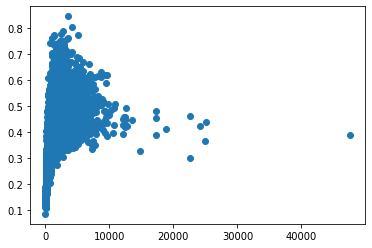

In [256]:
import matplotlib.pyplot as plt
plt.scatter(text_len_list, max_diff_list)

In [294]:
for doc in client.article.crawl.find():
    text = re.sub(r'\s+', ' ', doc['summary'])
    text_len = len(text)
    tokens = jieba.lcut(text)
    vector = model.infer_vector(tokens)
    filter = {}
    for i,value in enumerate(vector):
        filter[str(i)] = {'$gt': float(value) - 0.8, '$lt': float(value) + 0.8}
    ret_doc = list(client.article.dv.find(filter))
    ret_doc_ids = [ele['_id'] for ele in ret_doc]
    #if doc['_id'] not in ret_doc_ids:
    #    print(doc['_id'], 'not hit')
    if len(ret_doc) >= 5:
        print(doc['_id'], 'have %s hit' %len(ret_doc), text_len)

5ce41f3520d3b07abe77c7e9d5850add have 681 hit 278
182b92f1ddee1a0a2371702640a8c503 have 137 hit 538
9709b1e8bc7054a41267f48800fdea81 have 791 hit 68
c682b64a7d0a22227a21915696514bde have 800 hit 51
c2c01ca71f36ee02b5cea53b91838d37 have 130 hit 346
406c2e035c03e6d845e66dfab8f84a21 have 30 hit 278
c8ff1f3aa2fab392d0929c24b9deb2f1 have 364 hit 361
9ceee4639983c8f6345694dec220db4b have 840 hit 51
389b38759f2610d25d4daa97dafaf2c8 have 607 hit 336
1f60bc43cf1ed69087cebd4ad2f90c78 have 130 hit 496
4552de6193bba3bef291eda6979dff10 have 266 hit 361
59c04a84dc8c8a47ed4bc55bdf78a574 have 925 hit 85
01851a74d8d53d852ae8282b3739e7c9 have 586 hit 328
423e4df84e6a896226cdbfbcd5e296d5 have 5 hit 811
b0ff864b70b765d32db752954a915d4d have 431 hit 330
bf895ebe577cbbcfba75c3266c7e9f39 have 5 hit 637
d6a9b8956becc555594de7d1e1469e28 have 5 hit 811
b47413b95fa4c0612bf2f9ab2fa58cce have 5 hit 810
933d5dc9b9271b7857f600eedb7b6b71 have 206 hit 312
f87b50e4aa06bae4b5e94224dca1c719 have 256 hit 351
ae1b96e34ea2f

fc9f474e952a4a2dc2a29cbde76a3168 have 793 hit 271
8e7bca49cb23c56b02a9caa9feeadd83 have 1022 hit 64
07402a19be6a77e757d390f41b678071 have 703 hit 258
5e6a31148e6b6d9f3dc27fe373767188 have 848 hit 89
47fe4839650f7796498501f079b35c60 have 1037 hit 57
52983a884cd18ffd0d73bb3231be7c81 have 1007 hit 73
57bfa6c12d361268e4afb190905c5c1d have 50 hit 293
786dd79570f59cbec095c047ac1d0ca9 have 6 hit 1166
250c4e55877d96a2977d592a108e84a7 have 1001 hit 176
178806dfaf46c7db2f8468fa2387fd29 have 514 hit 315
9b6ca04e3ee05bcb944ea6ee7e905f06 have 508 hit 250
0fe82192c22bc055f7a56b96ca3e2cba have 173 hit 370
3d199be812fe3890001be09b94169895 have 61 hit 383
a2352095b9a952d8eed4b3dd2a98f166 have 36 hit 345
c39b103cb579fcd6daef8b7081c29a6f have 14 hit 448
86596d21c789ae9f3bb5de96421a93d9 have 415 hit 224
64369ad03bda39840ef47ae312bf776f have 102 hit 234
3dfa441d7fba6b330613c4bc13dd5f92 have 964 hit 121
8531d51c31fe42923b52b438801b7ee9 have 207 hit 273
752812d5d9fe87b122c00759ae93c720 have 274 hit 283
e2de3

b8c11876c60d74b0606c29554a995f93 have 857 hit 285
8d758f0b020dd4302dfea808b701153a have 796 hit 188
ba585a862abb949e3f8b0154bbb0ac10 have 421 hit 278
ba921740c3dcb09fa181a5b58993484b have 908 hit 240
d9686a57b14e11049731cce9e680a03f have 8 hit 597
580c49296e4b0bbb04476a789a74810c have 855 hit 54
9697772efc4eb994cd299159f248b87b have 946 hit 176
af97c73e41071793cea8327cc255e500 have 1133 hit 128
c182f63ab396e89933f2336ddd61b1a2 have 869 hit 54
4edfb2ebc6b4957ceb54cbee5d4a09ec have 748 hit 285
8c93e4b6a4c31cb0471a276fb0298945 have 13 hit 365
2f326191e2b71828c01c8db71e61c403 have 507 hit 617
2a534845a649afc9780d6a9baac7e35d have 23 hit 348
b42e4fca29c085456bd677672359e699 have 17 hit 348
933e17fb9db47764a25b342683ad55fe have 982 hit 175
2587bf810b95c7e3bbd0f0532437098b have 937 hit 155
7c1a76639f7dc709ef718799f777a8a3 have 1043 hit 146
adecf3715c4547a6c5a687411ae63dbb have 358 hit 611
06323fcbb6f7efa0a9d856c23934aa67 have 5 hit 514
2b837fcb41978a5f1c586719d3750ed8 have 934 hit 156
a842307

d9c34faa5ea8ac81016657b4adbd603b have 805 hit 133
71399f76efddb1eb0f519ca189633696 have 649 hit 261
391c775f8434810b3b66d9cba8dc9ffe have 370 hit 254
7d462c77faee4f6cf9faa6eaef44a6b9 have 25 hit 303
57d47f8e54f07e83e12d40e9c1d79848 have 955 hit 127
794f62b9995fc861397299454b3a08bc have 621 hit 205
5340c53ad4a4d4db8f44a11a5612b7ac have 7 hit 375
bdbb1dbd291e1ddd35e34b852f335bd1 have 53 hit 422
e37ed5e9208540f1af9d5cfd1de76087 have 950 hit 110
cfced879a7ce399524796745607a0519 have 1022 hit 110
5b598e834c86c15fbf4824be2662d4ea have 40 hit 342
72ca7e20eb16c0726aa7467e6438fc09 have 12 hit 563
9f8552a053216f07d22770a3efefeac6 have 778 hit 242
99f809f5de5decb8926ebb98ae539fe5 have 567 hit 254
4b518e3342dae379fbca41bab0025c27 have 29 hit 467
82450e56378e6dd0e9994655a2763df2 have 27 hit 519
3005b9636833d9c05c381bfce7362e6c have 679 hit 186
68f7f9046d6803eb4c16ded027edc14e have 276 hit 176
258f0f0d6026ac9ccf1dcbccf1f8e295 have 406 hit 247
3ee3c047d803d7cd594fcaa96715cbec have 871 hit 100
fc0811d

41186edc9c3071ba0bf368cbd0c6f089 have 8 hit 489
5aa634d60921ebe56058eb5dbe27b43f have 1146 hit 164
b959513fc55197b44502729b765d0cc2 have 835 hit 180
6929230a1be14cc7c7fa343dcf4ea7e0 have 141 hit 324
4479f2588e7d95736bfeb34baa1f8d36 have 92 hit 307
4fdfbe92edf1f2dfd46bce7e448fe2d1 have 7 hit 521
cb83438e0e8c83a70f8568df47cc7a53 have 91 hit 388
b8aaea76adb89eefb793fd41d079dd1d have 13 hit 371
479f892be70ff8803a5a6ea26ac3808c have 222 hit 357
310519f11206f6f6639201b611042563 have 1066 hit 158
a30803a528723564350819a3f10a08a5 have 1010 hit 190
c5c87c4ddf0c3c83ec1214ee7844a371 have 70 hit 413
1993a5229647550317b53f083748a557 have 836 hit 226
08c55e8784a6ba62a2d88d53c88a09b4 have 7 hit 469
37bb688d3252d4e80822fc212577257a have 1111 hit 162
3486a4c7bdab791eb1f67fd50b1bc094 have 674 hit 267
257ec073df15f95a5f2a694c4e1a974a have 23 hit 399
9fa02e47c994cd068feae39b0e21da6e have 319 hit 284
baa5775b27da12f0f16fc6c852232611 have 395 hit 175
249a2bfb727b74aca41f389e7bb2bc34 have 245 hit 294
6af3f2e

225a53295c11a75f2df3d289f02c3d0d have 68 hit 430
e1bc7d29756d06324da1ed877c075a9d have 474 hit 226
3b2c1360baa903f0f8fb88dc436fac4c have 189 hit 228
3e39760e11a30ffd8421bbf255cf6a38 have 936 hit 130
e20aabbddefae19bc0164a5f12058c10 have 907 hit 121
f31dfba218e96f918bc15c00cefb3a09 have 791 hit 220
034f398ac9440ad196076cf8b2f1eb35 have 908 hit 130
1edce5a275c23319c82d7e905f4c5751 have 657 hit 123
0fe0331a9f6f4e1a97095f434582728e have 839 hit 225
ae694a3d122b863d869e2b5d1e9a3873 have 982 hit 138
8d1dee6fc785e076cee25e13867605f1 have 6 hit 388
752529a479dc0ad98fb674eccb7f96ec have 886 hit 164
79ee185f6957f051557752c714100e68 have 530 hit 223
fce8dec0debf9b28dfcfac6f6fee7b06 have 798 hit 163
1a6ccd629991a1e08cc6a2073da3d214 have 7 hit 323
c1fca5e132ff25496849f6242f96b124 have 356 hit 290
2eaf51a6da17b24ec9f84e9433f13077 have 70 hit 604
751d5e2be36f7c6e03b974cd679a5132 have 20 hit 123
494aa5381bb24ec7df47de66e0e10fb9 have 864 hit 66
9850ae2c3e10cd87960bb40b0bd15364 have 792 hit 216
f1bbe139

0e08d1faa479f2caa61328c66a20635a have 143 hit 189
f6b84d4387a1d8090b8a213c7f0c8e17 have 23 hit 451
b0a659a8f23ae918abef9b75e44320b4 have 12 hit 574
8a74f275b547e05db0dae09680b02e73 have 775 hit 285
30b12c268db12e717965179823ec90ed have 58 hit 312
e49c9facaa9eedc25c14f06a2ce095bc have 430 hit 199
5fff908ea591f48c31350eb9a301cec0 have 526 hit 220
bd397ac0b6349b3dc60225c7ebe2b8c4 have 94 hit 358
50821483b99b26ed02bad3299000d1e2 have 29 hit 425
8cc30d68844f4a7537e88ef283bd6f55 have 90 hit 371
140088881ca4ed181979088b148b52bb have 823 hit 159
364006fe49ead9a230bbfb742733bbc1 have 163 hit 371
25f16218fd8ee89625ee7f9009b67d51 have 73 hit 501
78d25372950627051924d71951276972 have 407 hit 302
ce959f33f5c01f934857814d07c7a7f7 have 8 hit 410
e6dcb5ec2e16f58e45cd9fcb3de639fa have 11 hit 323
dfa186b48ca41981d8c3980e24d28bd9 have 1083 hit 120
43cbed1ec3540f2a9d1565166070706f have 859 hit 78
400b9c28e975536e0c26d0cea775306f have 892 hit 77
a2bf97945acee953a805172927f7bd0b have 915 hit 82
63ea5a218b60

ca5b603bb9478798f8321af8aaba90f0 have 17 hit 535
d00178b3bd3f93c9cbbf696f2cac6a2a have 181 hit 286
b6623e766c2107490c071fb5c31c6694 have 597 hit 408
be9d1053dd68747280fe41251f7c27bd have 350 hit 421
f49d8430efd747b393cf5203aa187430 have 253 hit 272
b4ff42081f86735998f8586dc0d34831 have 8 hit 417
08a5500e0d8f84b727bb0203c74bfd85 have 965 hit 129
2a39c7873fc60ae3a3a0885cdae0b900 have 9 hit 383
ddca00abaa995fee2974c941d9cf29ce have 252 hit 374
1d29f7d5fb6734c09a63e851baecadae have 548 hit 257
5466d3c91d87d11e0295b2ed521e2c32 have 136 hit 221
e0ce6238e01792d915b268ddb6b37f39 have 945 hit 207
5b5a249c4c077d44327b5af468cb66a9 have 731 hit 148
ba1e163f1faaf4160ade3f920fee00b7 have 943 hit 52
3056752b62acb379200c4a0ca7ce9d43 have 10 hit 675
fbfa09039c0f6fc9e6885589c1d483d6 have 9 hit 664
ca60bd33ec594ffba8d9b361ddfb55f7 have 75 hit 559
8db527590cd15540a6fbc6b4f1b1e24a have 9 hit 411
88c60f53f5daa36d8382b8cb04f46d72 have 939 hit 92
c0f913e73feb1060cb724baf092e690c have 308 hit 454
b2fce76e43ea2

2bfb75862f1cba87c6176bf2eddb2a70 have 1000 hit 87
c309fdb351f48fa79db5db3c42944c97 have 583 hit 86
1333e50ef4854a30421acc065f5a05bc have 830 hit 86
c89f28450bbf07a5b5a89c93c02b1c4a have 10 hit 399
cdc5b0353ffde29ca8c48d18f50c14f9 have 19 hit 358
f0d200e69172337ee53e000f824ef8eb have 39 hit 352
5c047d4df49b029fe573206da2ce3423 have 474 hit 136
462082b1d58a7742ee5fde8dd40eacea have 49 hit 330
734dfe50c8a52737202040f854ab1148 have 36 hit 342
9c4572a360730606be8450b57298d042 have 32 hit 343
1fd2104dbe661ab4a5fad1485c9e2d13 have 29 hit 331
ef5b2ccad363c1f1775a9724449e2f00 have 847 hit 96
29fa0c95395b887dbd1543f3dc649ff2 have 510 hit 194
9dd01e944710b7b6636cc14c8e866574 have 809 hit 108
06926550e58514086f6e323f6e11c5e6 have 1008 hit 117
ed76180aa6eb90fc858ab67e9e4f4b01 have 15 hit 177
45c401b2114024ef1cfdbae7a04af900 have 13 hit 281
ab2290dc24947071bc7c5509fc296181 have 273 hit 192
dba24a7ce9cac42488fc7335326fb93f have 856 hit 100
491a349310dc558658ed048acb877e4e have 492 hit 103
d338cb6faae

4ba8ba377d46685483d5df29f4c1071a have 543 hit 376
78fde6b779c48473bde203595e3eaf05 have 594 hit 338
28f2142340c55adb0befe60a05c097fb have 162 hit 352
4d18c517c0bbf1e3859bb687872071fa have 307 hit 361
23fef99b00e43e722dbccbb1dda00ab7 have 19 hit 425
a0f7556822b3b870a0369ec9d89a2849 have 269 hit 330
eb96986c4c0c0eb479388b5a40034a11 have 257 hit 329
59a30b491e6610406c3329756dc0546d have 898 hit 291
4a38071ff062bbb647418290acae3990 have 705 hit 297
0f44e995521049e59d95bd9fa20ac3e4 have 445 hit 318
8e319494b0c44df98e618d4918bf48d4 have 104 hit 344
b3063d57ab7f42e76eeb93624891bb2e have 636 hit 53
d56dee81240a22cd842b243518b22eab have 712 hit 123
a88544f64fb1ca82886a3b0aa504086c have 978 hit 209
9dd118e1667c62a8767e061230a37dee have 448 hit 375
0d0655ab18459029e16c159c62d5829a have 112 hit 428
5ccd48a228a90bb155e0c57e2dd74620 have 23 hit 450
163ecb35b0c796aca1e1d1c5a3469faf have 16 hit 521
d8a0634bd6f924ad6c95a460fc109dc5 have 844 hit 199
2952ce8e93454ca68363d067381054a8 have 50 hit 397
63e9c

0e4394a140e8ecbdae79940d7c656a28 have 1142 hit 167
f02e1091d38c68163acc146f796ddff6 have 1093 hit 211
4ee595bbf9a73776b9666387a106f07a have 871 hit 190
92c6959f61598ea37098076f03720a95 have 798 hit 96
5df2a9b818696a91a874e5d181713168 have 590 hit 213
f8e8f389533efced612d1e46ee74b955 have 513 hit 217
3a83a3a85d30987b70ac4078e2e4f8cc have 1077 hit 144
af8b12fe16cb43f58f6264662ef5e275 have 1086 hit 165
0472ff59c23af44f7c36882cb99ba5d9 have 1006 hit 63
2dbe95f77d40a2b05e7b37e27cf892b2 have 1040 hit 154
71fc69e47917b49f41d39a4427a960e8 have 117 hit 325
58507bfcb7406e31ff58f7206796ebb0 have 824 hit 203
7d04c09d1229513b98d592950b542e0c have 155 hit 328
7dd273e27ce34fb0db7036e0d0bea673 have 197 hit 398
e260083714822a52794bc21732b35e1a have 917 hit 140
5ddc651a62fa53bb47000e8dc2b097ae have 18 hit 462
a82a994844599dbda2e34aed3012f0ee have 1125 hit 102
2568727802920cd6e229e18ae1f31eed have 912 hit 172
6d4889f6c39ffc026eed181bcc63c183 have 97 hit 439
f02ec92af9347b7547e88be9fbf7abf8 have 383 hit 3

dce48f0ac8f0124290458ee9264a8d78 have 15 hit 361
dd2f4a97e86e8bce64b0a845cc187224 have 506 hit 403
de6283d0532eaa90ff38e861e8eec609 have 953 hit 87
68354a4914a9ce3136a0320b5ccb012c have 648 hit 342
9bd95f69de24ab9b0bb562910badc597 have 872 hit 55
99ef38423f94a066af509d5b710a2122 have 977 hit 192
30ece62b35eae9cb75c1b8a4362a29ea have 1022 hit 135
32e47ba4ba12a9f868a32d9742734c16 have 156 hit 363
6bc8e899f3cd2fcaac37521e47f4b836 have 77 hit 360
3fe86753e4f1ff0f5dc1e254c0baca30 have 33 hit 370
297ac4464ba4ae9845c792f367f9d0c1 have 16 hit 464
89399961d76c4090550a118fbb57d5db have 570 hit 206
7737ea8c1da854122541431749caf8af have 874 hit 100
402a31fb24db56c400ecbfcb0190c901 have 146 hit 357
e0b79ec2218a7da411a9010258bd611f have 10 hit 737
cf42a2dc42f2fb38be3ff871857837e1 have 5 hit 429
6224b5480f9a37cc44edf52cdf382a63 have 749 hit 144
cc789cff2e166a547e99f7aa8420711c have 636 hit 207
a6230591c4c55605e1ef2e354fe02ed1 have 78 hit 398
3347964526455f3bda25f32bc5f131ea have 376 hit 301
67a801ef4

In [276]:
client.article.crawl.find_one({'_id': '406c2e035c03e6d845e66dfab8f84a21'})

{'_id': '406c2e035c03e6d845e66dfab8f84a21',
 'links': [{'type': 'text/html',
   'href': 'http://theory.people.com.cn/n1/2021/0802/c40531-32177480.html'}],
 'proposer': 'admin',
 'authors': [],
 'tags': [],
 'title': '深化西方哲学史研究（新书评介）',
 'summary': '\n\t冯俊主编的《西方哲学史》一书，已由人民出版社出版。该书在哲学、哲学史和哲学史编纂学三重维度下展开哲学史书写，努力反映国内西方哲学史研究的最新成果。 \n\t该书主要具有如下特色和风格：首先，坚持以马克思主义的立场、观点、方法指导西方哲学史研究，辩证地看待哲学发展史中的必然性和内在联系、偶然性和外在联系。其次，既梳理了哲学的发展历史，又注重为发展当代哲学服务；既考察哲学自身的逻辑，又考察哲学和所处时代的政治、经济、文化、社会、科技、宗教、艺术等的关系。再次，体现了中国学者对西方哲学的独特研究视角和理解维度，努力在中西文化融合中拓展西方哲学研究的意蕴和内涵。 \n\t',
 'updated': '2021-08-02T11:31:45.120337',
 'similar_paper': ['7a1c1b25c128549e5a43221a34b5f463',
  'c12ae896aa3900fa8ecaf0d5e5ec5685',
  'df9da55d8c603d2bfb21f936a8ea0173',
  'c43a697287246de082416d3fe904213a',
  '0a600b6e639bb6b457bfb056ac5f7fec',
  'ef364508c95a38a2a335382449aab92c',
  '01b6a5790238a11ff7d1a5da8e930ecf',
  'cf6f83954f553954b1e7f837d7d7fc65',
  'a2fdc0cb383d5239b3041692b3308353',
  'f0d670c165c00871d85d3ff1725e3a29'],
 'topic_index': 5}

In [291]:
doc = client.article.crawl.find_one({'_id': '9cd9debde94713db0c78e8c3997e1a02'})
text = re.sub(r'\s+', ' ', doc['summary'])
text_len = len(text)
tokens = jieba.lcut(text)
vector = model.infer_vector(tokens)
filter = {}
for i,value in enumerate(vector):
    filter[str(i)] = {'$gt': float(value) - 0.8, '$lt': float(value) + 0.8}
ret_doc = list(client.article.dv.find(filter))
ret_doc_ids = [ele['_id'] for ele in ret_doc]
print(ret_doc_ids)

['9cd9debde94713db0c78e8c3997e1a02']
